# OpenCV for MathVision

Installing opencv2, numpy, matplotlib, and sys.

In [376]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import math

Reading and displaying the starter image. Image resizing is temporary and only for displaying purposes.

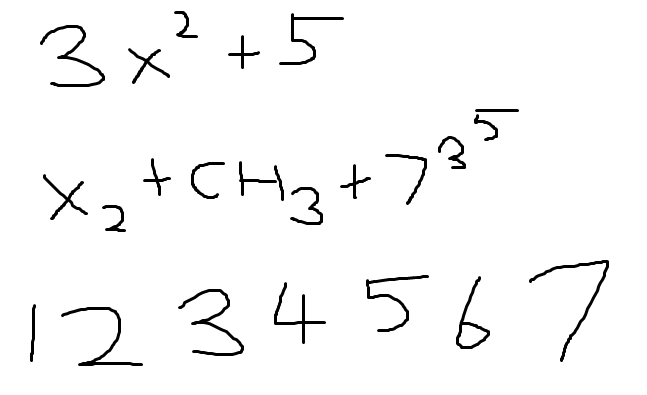

In [377]:
image = cv2.imread('/content/multiline.png')
cv2_imshow(image)



# TLDR
In order to calculate and crop the bounding boxes of the images, we first need apply a threshhold to an image. This essentially means that we are "binarizing the image". Here, any pixel color value lower than the threshold is set as 0, and any other is set as 1.

With the cv2.threshold(image, thresh-val, max-val, thresholding types) function this is achieved. Here is the breakdown our code:

1.   Image is converted to grayscale
2.   We apply a binary threshold and otsu threshold to the image
3.   We apply a dilation on the threshold image
4.   We create an inversion of the threshold image

## Full Breakdown

Upon converting the image to grayscale we apply a binary threshold and otsu threshold to the image. For the purposes of this portion of the project we need the binary conversion to be very strict, and with otsu binarization this is achieved.

![otsu.jpg](https://docs.opencv.org/3.4/otsu.jpg)

**What is otsu's binarization?**
In our original thresholding methods, we input a general threshold, and then use an arbitrary value as a threshold. With otsu's binarization, we **optimize that**, where instead of us choosing the threshold, otsu does it for us. The way this works is by choosing a threshold value for an image which only has two histogram peaks (see example image). The example also shows how using gaussian filtering optimizes the otsu work.

Note: When using the otsu binarization the passed in threshold values are arbitrary.

**Dilation**
Following these changes, we use dilation which is a basic morplogical operator used for "growing" the image.

We also create an inverted mask if the image, which is used in later parts.

In [378]:
'''prepare_image gets the dilation and inverted dilation masks in black and
white for easier reading of characters by applying gaussian blur and Otsu
binarization.

Args:
  image (3-D Numpy Array) -> is the image that is loaded from the system/REST
  call that is meant to be converted to LaTeX.

  dimension_size (Tuple) -> is a tuple containing two elements that represents
  the ksize of the structuring element, is used to help cv2 library read
  different shapes. (Such as having a bias towards reading a whole line vs an
  individual character).

Returns:
  dilation (3-D Numpy Array) -> contains the dilated version of the black and
  white version of image.

  inverted_dilation (3-D Numpy Array) -> contains the dilated version of the
  black and white version of image, but is the inverse of dilation.
'''

def prepare_image(image, dimension_size):
  img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  img_th = cv2.GaussianBlur(img_gray, (5,5),0)

  ret,thresh1=cv2.threshold(img_th,0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
  rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, dimension_size)
  # Applying dilation on the threshold image
  dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)


  inverted_image = cv2.bitwise_not(img_th)
  ret1,thresh2=cv2.threshold(inverted_image,0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
  inverted_dilation = cv2.dilate(thresh2, rect_kernel, iterations = 1)

  return (dilation, inverted_dilation)

# Getting Contour Data
When we call for the contour and contour inverse data, we get an array of arrays containing x,y coordinates of contour points.

However, when .findContours is used, it detects only the darker color on a lighter foreground. If for example, the image was written in white writing on a black background, the contours data would be very small. Due to this, we compare the length of the contours data. Whichever has an array with more data points will be the contour data with actual information.

In [379]:
'''get_contours finds image contours based on the dilation and inverted_dilation
versions of an image. Is used after calling the prepare_image function.

Args:
dilation (3-D Numpy Array) -> is a black and white version (2 colors) of the
original image dilated.

inverted_dilation (3-D Numpy Array) -> is a black and white version (2 colors)
of the original image dilated, but has the inverse colors of dilation.

Returns:
cntrs (Array) -> is a list of Numpy arrays where each
Numpy array has a x and y values (x,y).

'''
def get_contours(dilation, inverted_dilation):
  # Finding contours
  contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                  cv2.CHAIN_APPROX_NONE)
  # Finding contours inverse
  contours_mask, hierarchy = cv2.findContours(inverted_dilation, cv2.RETR_EXTERNAL,
                                                  cv2.CHAIN_APPROX_NONE)
  if len(contours) > len(contours_mask):
    cntrs = contours
  else:
    cntrs = contours_mask

  return cntrs

# Bordered Images & Cropping

One problem we faced while writing this script was that images with a background to the main color would only get cropped once. For example, if you took a photo of text on a white sheet of paper, but the sheet of paper had a black background behind it, the contours would only return the borders of the white sheet.

To deal with this we wrote a while loop, which would run as long as the length of the contours array is <= 1, and a counter variable is less than 16 (to make sure that in case the image is alternating, we won't throw an error).

In this loop we use keep track of the max and minimum x values, and crop the sheet at these points. Then we find the contours again, and increment the counter. If after this we still see the contours to be <=1, we crop again.

In [380]:
'''prepare_crop acts as a wrapper function to help the border cropping of the
image. The prepare_crop function calls the prepare_image function to get the
dilation and inverted_dilation of the image. Then it gets the contours by
calling the get_contours function, and finally it calls border_fix.

Args:
  image (3-D Numpy Array) -> the original image to be converted to LaTeX.

Returns:
  border_fix(image, dilation, inverted_dilation) (3-D Numpy Array) -> the
  converted image that is the original image but without borders and skew
  corrected.
'''
def prepare_crop(image):
  dilation, inverted_dilation = prepare_image(image, (1,1))
  cntrs = get_contours(dilation, inverted_dilation)
  return border_fix(image, dilation, inverted_dilation)


In [381]:
'''border_fix takes in an image, dilation and inverted dilation mask and returns
an image that has its borders cropped, and is skew corrected.

Args:
  image (3-D Numpy Array) -> The original image to be converted to LaTeX.

  dilation (3-D Numpy Array) -> The black and white version of the original
  image that has gone through otsu binarization that is dilated.

  inverted_dilation (3-D Numpy Array) -> The same as dilation, but with inverted
  colors.

Returns:
  cropped_image (3-D Numpy Array) -> A cropped version of the original image
  such that there are no external borders and that the image is skew-corrected.

'''
def border_fix(image, dilation, inverted_mask):

  # Initializing temporary variables to be used
  final_contours = None
  counter = 0
  cropped_image = image.copy()


  # Finding contours
  contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                  cv2.CHAIN_APPROX_NONE)
  # Finding contours inverse
  contours_mask, hierarchy = cv2.findContours(inverted_mask, cv2.RETR_EXTERNAL,
                                                  cv2.CHAIN_APPROX_NONE)

  contour_len = len(contours)
  contour_mask_len = len(contours_mask)
  # Determines the maximum contour length of both
  final_contours_length = max(contour_len, contour_mask_len)

  ''' If the contour length is greater than 1 for both not inverted and inverted,
  then we assume that one of the masks does not include any borders. The problem
  before is that the contours would be found, but it would just end up finding the
  contours of a border
  '''
  while final_contours_length <= 1 and counter<16:

    if (contour_len and contour_mask_len) <=1:

      x1,y1,w1,h1 = cv2.boundingRect(contours[0])
      x2,y2,w2,h2 = cv2.boundingRect(contours_mask[0])

      if w1 * h1 <= w2 * h2:
        src = np.array([[x1,y1],[x1, y1 + h1],[x1 + w1, y1 + h1],[x1 + w1, y1]], np.float32)
        dst = np.array([[0,0],[0,h1],[w1, h1],[w1, 0]], np.float32)

        # Getting the linear transformation to be used to warp the image
        MT = cv2.getPerspectiveTransform(src, dst)

        # Remove any rotations, warping issues with the image
        cropped_image = cv2.warpPerspective(cropped_image, MT, (w1, h1))
        dilation = cv2.warpPerspective(dilation, MT, (w1, h1))
        inverted_mask = cv2.warpPerspective(inverted_mask, MT, (w1, h1))

        final_contours = contours
      else:
        src = np.array([[x2,y2],[x2, y2 + h2],[x2 + w2, y2 + h2],[x2 + w2, y2]], np.float32)
        dst = np.array([[0,0],[0,h2],[w1, h2],[w2, 0]], np.float32)
        # Getting the linear transformation to be used to warp the image
        MT = cv2.getPerspectiveTransform(src, dst)

        # Remove any rotations, warping issues with the image
        cropped_image = cv2.warpPerspective(cropped_image, MT, (w2, h2))
        dilation = cv2.warpPerspective(dilation, MT, (w2, h2))
        inverted_mask = cv2.warpPerspective(inverted_mask, MT, (w2, h2))

        final_contours = contours_mask

    counter+=1

    # Finding contours
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                    cv2.CHAIN_APPROX_NONE)
    # Finding contours inverse
    contours_mask, hierarchy = cv2.findContours(inverted_mask, cv2.RETR_EXTERNAL,
                                                    cv2.CHAIN_APPROX_NONE)
    contour_len = len(contours)
    contour_mask_len = len(contours_mask)

    final_contours_length = max(contour_len,contour_mask_len)

  return cropped_image

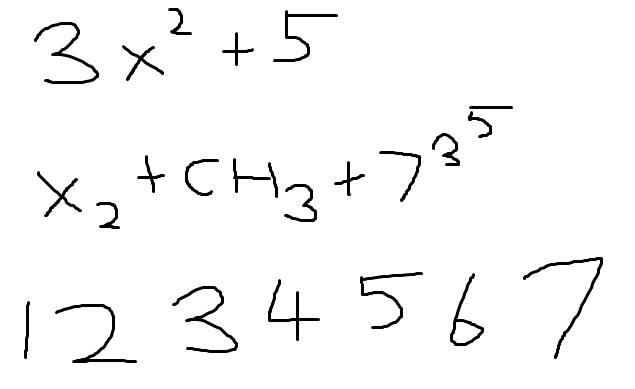

In [382]:
cropped_image = prepare_crop(image)

# Cropping the borders by 1% if case any there was unclean cropping of image
height_diff = int(cropped_image.shape[0] * 0.01)
width_diff = int(cropped_image.shape[1] * 0.01)

cropped_image = cropped_image[height_diff:cropped_image.shape[0] - height_diff,
                              width_diff:cropped_image.shape[1] - width_diff]

cv2_imshow(cropped_image)


In [383]:
dilation, inverted_dilation = prepare_image(cropped_image, (100,5))


im2 = cropped_image.copy()
cntrs = get_contours(dilation, inverted_dilation)

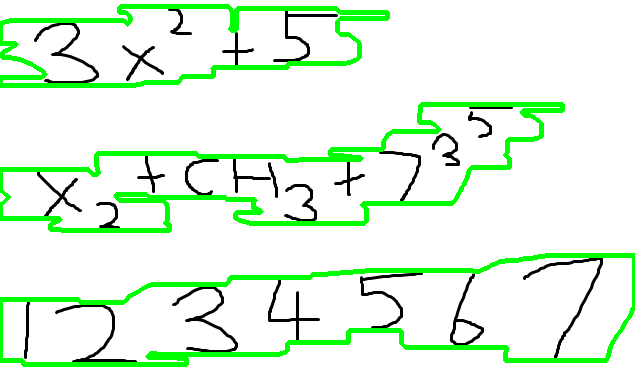

In [384]:
cv2.drawContours(im2, cntrs, -1, (0,255,0),3)
cv2_imshow(im2)

# Extracting Contours

To extract the contours, we want to be able to extract them as a rectangle, but at the same time we only want to keep the information within the green contours shown above. To do so, we will utilise a mask that will fill the rest of the image besides the contour region of interest (ROI) with black, and the ROI with white. Then we will crop the image and save it to some variables. The extract_contours function will crop an image based on the contours (the
green lines pictured above) and will fill the rest of the cropped image such that the image is rectangular.

In [385]:
'''common_color gets the most common color, which is usually the background
color.

Args:
  img (3-D Numpy Array) -> The original image to be converted to LaTeX.

Returns:
  common_color (Array) -> An array of 3 integers that represents the most common
  color.

'''
def common_color(img):
  unq, count = np.unique(img.reshape(-1,3), axis = 0, return_counts = True)
  common_color = [0,0,0]
  common_color[0], common_color[1], common_color[2]  = unq[np.argmax(count)]

  return common_color


In [386]:
'''add_background applies the b_color (the background color) to all pixels
outside of the region enclosed by cntrs, or the contours of an image.

Args:
  img (3-D Numpy Array) -> The image that is to be applied the background color,
  could be the original image, could be the image that is represented by a line,
  could be another image.

  b_color (Array) -> An array containing 3 integers that represents the
  background color of an image.

  cntrs (Array) -> An array containing a Numpy Array that contains two
  variables, x and y, (x,y) that represents a coordinate point on the image
  img.

Returns:
  mask_image (3-D Numpy Array) -> img but with the b_color applied to all
  regions outside of the area enclosed by cntrs.

'''
def add_background(img, b_color, cntrs):
  mask_image = img.copy()
  mask_value = 255
  b_mask = np.zeros(img.shape[:-1]).astype(np.uint8)
  cv2.drawContours(b_mask, [cntrs], -1, (255,255,255), thickness=-1)

  selection = b_mask != mask_value
  mask_image[selection] = b_color

  cv2.drawContours(mask_image, cntrs, -1, (int(b_color[0]), int(b_color[1]), int(b_color[2])), 1)

  return mask_image

In [387]:
'''extract_contours returns an array containing the bounding boxes and the
cropped images based on cntrs applied to img.

Args:
  img (3-D Numpy Array) -> The img to be applied on (could be any image).

  cntrs (Array) -> An array containing a Numpy Array of coordinates (x,y) that
  represents the Region of Interst (ROI) of an image. (ROI in this case woudl
  be the area of img that contains text),

  common_color (array) -> An array of 3 integers that represents the most
  common_color (the background color).

Returns:
  arr (Array) -> An array of images (3-D Numpy Array) that represents the image
  cropped based on the bounding boxes from the contours. Note that the images
  are cropped based on the individual contours, which can by in the shape of
  any polygon, and not the bounding boxes, which can only be a rectangle. To
  make a rectangular image, this is where the common_color would be applied.

  bounding_box (Array) -> An array of bounding boxes, which are tuples of 4
  integers (x,y,w,h) where (x,y) is the top left of the image, and w is the
  widgth and h is the height.
'''
def extract_contours(img, cntrs, common_color):
  channels = None;
  if (len(img) < 2):
    channels = img.shape[2]
  else:
    channels = 1
  arr = []
  bounding_box = []

  for cntr in cntrs:
    mask = np.full((img.shape[0], img.shape[1], 3), (0, 0, 0), dtype=np.uint8)
    ignore_mask = (255, ) * channels
    cv2.drawContours(mask, [cntr], -1, (255,255,255), thickness=-1)

    mask_image = cv2.bitwise_and(img, mask)
    x, y, w, h = cv2.boundingRect(cntr)
    box = (x,y,w,h)

    bounding_box.append(box)

    filled_image = add_background(mask_image, common_color, cntr)

    # Crop the image
    cropped_line = filled_image[y:y+h,x:x+w]
    #cv2_imshow(cropped_line)

    arr.append(cropped_line)
  return (arr, bounding_box)


In [388]:
def binarize_img(img):
  im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  th, im_otsu = cv2.threshold(im_gray, 192, 255, cv2.THRESH_OTSU)

  cv2_imshow(im_otsu)
  return im_otsu

In [389]:
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
b_color = common_color(cropped_image)

(cropped_lines, bounding_box) = extract_contours(cropped_image, cntrs, b_color)

Next, the cropped_lines and bounding_box variables will be concatenated into a dataframe called boxcoords and sorted based on the y1 values, or the bottom y values (since typically text is written with the characters at a similar lower y value). The dataframe is then sorted vertically to determine which line comes first.

In [390]:
boxcoords = pd.DataFrame([], )
label = ['x', 'y', 'x1', 'y1', 'image']

for i in range(len(bounding_box)):
  boxcoords = pd.concat( [boxcoords, pd.DataFrame([bounding_box[i][0], bounding_box[i][1], bounding_box[i][0] + bounding_box[i][2], bounding_box[i][1]+ bounding_box[i][3], cropped_lines[i]])], axis='columns')


boxcoords = boxcoords.transpose()
boxcoords.columns=label
boxcoords = boxcoords.reset_index()

boxcoords

,index,x,y,x1,y1,image
0,0,0,255,635,365,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,0,0,104,563,231,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,0,0,6,388,86,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [391]:
boxcoords = boxcoords.sort_values('y1', ascending=[True])
boxcoords

,index,x,y,x1,y1,image
2,0,0,6,388,86,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,0,0,104,563,231,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
0,0,0,255,635,365,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


## Identifying Individual Letters

To identify individual letters, the boxcoords dataframe containing information relating to each line of text is looped through and passed through the identify_letter function. The identify_letter function recurively calls itself until it can identify only one contour in an image, which is assumed to be the individual character. Within each call, a contour is identified and cropped so before either being added to the return lists (image and bounding_box coordinates) or being recursively passed on to identify_letter.

In [392]:
'''idenfity_letter_helper resizes the single_bounding_box coordinates to match
the coordinates of the original line image. This function is necessary because
in the identify_letter function below, the image is sized up to increase
readability for openCV.

Args:
  single_bounding_box (Array) -> An array of bounding boxes, which are tuples of
  4 elements (x,y,w,h) where (x,y) represent the top left of an image, w is the
  widgth and h is the height.

  x1 (Int) -> x1 is the previous x value of the image from the previous
  recurisve call of identify_letter.

  y1 (Int) -> y1 is the previous y value of the image from the previous
  recurisve call of identify_letter.

  resize (Int) -> The resize factor whenever the identify_letter function is
  called to increase readability.

  iter (Int) -> The number of recurisve iterations that an image has gone
  through. For the context of this function, the coordinates of
  single_bounding_box needs to shrunk down by a factor of resize^iter to
  represent the coordinates of the original line image.

Returns:
  return_box (Array) -> An array of bounding boxes (a tuple of x1,y1,x2,y2)
  where (x1, y1) represent the top left an image, and (x2, y2) represent the
  bottom right of an image.

'''
def identify_letter_helper(single_bounding_box, x1, y1, resize, iter):
  return_box = []
  for i in range(len(single_bounding_box)):
    bound_box = (x1 + single_bounding_box[i][0]/pow(resize, iter),
                 y1 + single_bounding_box[i][1]/pow(resize, iter),
                 x1 + single_bounding_box[i][0]/pow(resize, iter) + single_bounding_box[i][2]/pow(resize, iter),
                 y1 + single_bounding_box[i][1]/pow(resize, iter) + single_bounding_box[i][3]/pow(resize, iter))
    return_box.append(bound_box)
  return return_box

In [393]:
'''identify_letter identifies individual letters within an image. It is
assumed that image represents a line of text.

Args:
  image (3-D Numpy Array) -> An image assumed to be a line of text.

  line_images (Array) -> An array of images that will eventually be returned
  to represent a cropped version of the individual characters.

  single_bounding_box (Array) -> An array of bounding boxes that will eventually
  be returned to represent the coordinates (top left and bottom right of an
  image) of the cropped image (the invdividual elements of line-images).

  x1 (Int) -> x1 is the previous x value of the image from the previous
  recurisve call of identify_letter.

  y1 (Int) -> y1 is the previous y value of the image from the previous
  recurisve call of identify_letter.

  iter (Int) -> The depth of the recurisve call.

  dmx (Int) -> the x value to be used for prepare_image functionc call.

  dmy (Int) -> the y value to be used for prepare_image function call.

Returns:
  line_images (Array) -> An array of images (3-D Numpy Arrays) that represent
  the individual characters cropped.

  single_bounding_box (Array) -> An array of bounding boxes (Tuples of 4
  integers (x1, y1, x2, y2) where (x1, y1) is the top left of the associated
  image in line_images and (x2, y2) is the bottom right of the associated image
  in line_images).

'''
def identify_letter(image, line_images, single_bounding_box, x1, y1, iter, dmx,dmy):
  resize = 3
  if not hasattr(image,'shape'):
    return
  # To enhance the image
  image = cv2.resize(image, (image.shape[1] * resize, image.shape[0] * resize), interpolation = cv2.INTER_AREA)

  # Creating the sharpening kernel
  kernel = np.array([[-1,-1,-1],
                      [-1, 9,-1],
                      [-1,-1,-1]])

  # Applying the sharpening kernel
  sharpened = cv2.filter2D(image, -1, kernel)

  (dilation, inverted_dilation) = prepare_image(sharpened, (dmx,dmy))
  cntrs_line, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                   cv2.CHAIN_APPROX_NONE)
  sharpened_copy = image.copy()

  if len(cntrs_line) == 1:
    # Base case
    return_image = []
    return_box = []
    x, y, w, h = cv2.boundingRect(cntrs_line[0])
    box = (x1 + x/pow(resize, iter),y1 + y/pow(resize, iter), x1 + x/pow(resize, iter)+w/pow(resize, iter),y1 +
          y/pow(resize, iter)+h/pow(resize, iter))
    return_image.append(sharpened_copy)
    return_box.append(box)

    return (return_image, return_box)
  else:
    # Extract contours gets the width
    (arr, single_bound_box) = extract_contours(sharpened_copy, cntrs_line, b_color)
    # Need to base the contour coordinates based on x1, x2, y1, y2 values.
    single_bound_box = identify_letter_helper(single_bound_box, x1, y1, resize, iter)
    for i in range(len(arr)):
      (tmp_line_images, tmp_box) = identify_letter(arr[i], line_images, single_bound_box,
                                                   single_bound_box[i][0],
                                                   single_bound_box[i][1], iter+1, 1, 100)
      if(len(tmp_line_images) > 1):
        line_images = tmp_line_images
        single_bounding_box = tmp_box
      else:
        line_images = line_images + tmp_line_images
        single_bounding_box = single_bounding_box + tmp_box

  return (line_images, single_bounding_box)


In [394]:
'''resize takes in an image img and resizes it to a square based on the
dimensions width, height and preserves the aspect ratio by filling the rest
of the image with background_colour.

Args:
  img (3-D Numpy Array) -> The image to be resized.

  width (Int) -> The width that the image is to be resized to.

  Height (Int) -> The height that the image is to be resized to.

  background_colour (Array) -> An array containing 3 integers that represents
  the RGB values of a colour.

Return:
  resized (3-D Numpy Array) -> The image by resized to a square.

'''
def resize(img, width, height, background_colour):
  new_img = None
  # max_size denotes the shape of the square image, which would be max_size x max_size
  max_size = max(img.shape[0], img.shape[1])
  if max_size == img.shape[0]:
    to_add = int((max_size - img.shape[1])/2)
    # top bottom
    new_img = cv2.copyMakeBorder(img, 0, 0, to_add, to_add, borderType=cv2.BORDER_CONSTANT,
                                 value=(int(background_colour[0]), int(background_colour[1]), int(background_colour[2])))
  else:
    to_add = int((max_size - img.shape[0])/2)
    # right left
    new_img = cv2.copyMakeBorder(img, to_add, to_add, 0, 0,  borderType=cv2.BORDER_CONSTANT,
                                 value=(int(background_colour[0]), int(background_colour[1]), int(background_colour[2])))
  resized = cv2.resize(new_img, (width, height), interpolation=cv2.INTER_AREA)
  return resized


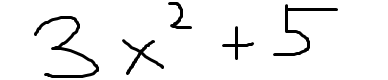

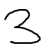

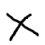

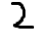

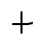

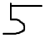

,x,y,x1,y1,image,shape,median_y
0,34.333333,10.555556,98.666667,80.0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(80, 388, 3)",45.277778
1,122.333333,33.555556,163.666667,80.0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(80, 388, 3)",56.777778
2,168.333333,0.0,191.666667,34.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(80, 388, 3)",17.277778
3,222.333333,20.555556,253.666667,65.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(80, 388, 3)",43.055556
4,273.333333,0.0,337.666667,61.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(80, 388, 3)",30.777778


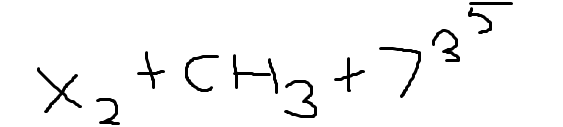

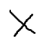

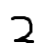

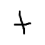

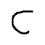

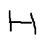

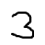

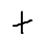

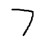

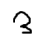

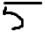

,x,y,x1,y1,image,shape,median_y
0,37.333333,61.555556,81.666667,118.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",90.055556
1,96.333333,92.555556,119.666667,127.0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",109.777778
2,137.333333,45.555556,164.666667,94.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",70.055556
3,185.333333,49.555556,218.666667,97.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",73.555556
4,233.333333,48.555556,277.666667,99.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",74.055556
5,284.333333,74.555556,316.666667,123.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",99.055556
6,334.333333,51.555556,364.666667,97.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",74.555556
7,379.333333,41.555556,420.666667,103.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",72.555556
8,432.333333,23.555556,459.666667,67.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",45.555556
9,468.333333,0.0,512.666667,39.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",19.777778


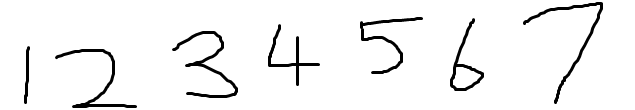

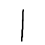

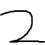

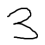

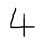

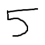

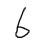

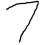

,x,y,x1,y1,image,shape,median_y
0,24.333333,40.555556,29.666667,109.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(110, 635, 3)",75.055556
1,55.333333,43.555556,136.666667,110.0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(110, 635, 3)",76.777778
2,172.333333,25.555556,237.666667,103.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(110, 635, 3)",64.555556
3,268.333333,18.555556,319.666667,91.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(110, 635, 3)",55.055556
4,360.333333,11.555556,422.666667,79.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(110, 635, 3)",45.555556
5,450.333333,12.555556,483.666667,96.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(110, 635, 3)",54.555556
6,523.333333,0.0,602.666667,109.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(110, 635, 3)",54.777778


In [395]:
line_info = []

for i in range(len(boxcoords.index)):
  img_shape = boxcoords['image'].iloc[i].shape
  cv2_imshow(boxcoords['image'].iloc[i])
  line_images = []
  single_bounding_box = []
  (line_images, single_bounding_box) = identify_letter(boxcoords['image'].iloc[i], line_images, single_bounding_box, 0, 0, 1, 1, 100)

  line_coords = pd.DataFrame([], )
  line_label = ['x', 'y', 'x1', 'y1', 'image', 'shape']
  for i in range(len(line_images)):
    resized_img = resize(line_images[i], 45, 45, b_color)
    line_coords = pd.concat( [line_coords, pd.DataFrame([single_bounding_box[i][0], single_bounding_box[i][1], single_bounding_box[i][2], single_bounding_box[i][3], resized_img, img_shape])], axis='columns')

  line_coords = line_coords.transpose()
  line_coords.columns=line_label
  line_coords = line_coords.reset_index()

  line_coords = line_coords.sort_values('x', ascending=[True])
  line_coords = line_coords.reset_index()
  line_coords = line_coords.drop(columns=['level_0','index'])

  median_y = []

  for i in range(len(line_coords)):
    cv2_imshow(line_coords.iloc[i, 4])
    median_y.append((line_coords['y'].iloc[i] + line_coords['y1'].iloc[i])/2)
  line_coords['median_y'] = median_y
  line_info.append(line_coords)
  display(line_coords)

#Identifying Subscripts and Superscripts
To identify subscripts and superscripts, the median y value is used.

In [399]:
def determine_special_functions(df):
  std = np.std(df['median_y'])
  y1mean = np.average(df['y1'])
  ymean = np.average(df['y'])
  median_mean = np.average(df['median_y'])

  spec_list = []

  for row in df.index:
    if df['median_y'].iloc[row] < median_mean + std and df['y1'].iloc[row] < median_mean:
      spec_list.append('sup')
    elif df['median_y'].iloc[row] > median_mean - std and df['y'].iloc[row] > median_mean:
      spec_list.append('sub')
    else:
      spec_list.append('reg')

  # print(f'std: {std}, y1mean = {y1mean}, ymean = {ymean}, median mean: {median_mean}')
  # print(spec_list)

  return spec_list

In [400]:
for i in range(len(line_info)):
  type_list = determine_special_functions(line_info[i])
  line_info[i]['character type'] = type_list

  display(line_info[i])

,x,y,x1,y1,image,shape,median_y,character type
0,34.333333,10.555556,98.666667,80.0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(80, 388, 3)",45.277778,reg
1,122.333333,33.555556,163.666667,80.0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(80, 388, 3)",56.777778,reg
2,168.333333,0.0,191.666667,34.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(80, 388, 3)",17.277778,sup
3,222.333333,20.555556,253.666667,65.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(80, 388, 3)",43.055556,reg
4,273.333333,0.0,337.666667,61.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(80, 388, 3)",30.777778,reg


,x,y,x1,y1,image,shape,median_y,character type
0,37.333333,61.555556,81.666667,118.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",90.055556,reg
1,96.333333,92.555556,119.666667,127.0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",109.777778,sub
2,137.333333,45.555556,164.666667,94.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",70.055556,reg
3,185.333333,49.555556,218.666667,97.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",73.555556,reg
4,233.333333,48.555556,277.666667,99.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",74.055556,reg
5,284.333333,74.555556,316.666667,123.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",99.055556,sub
6,334.333333,51.555556,364.666667,97.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",74.555556,reg
7,379.333333,41.555556,420.666667,103.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",72.555556,reg
8,432.333333,23.555556,459.666667,67.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",45.555556,sup
9,468.333333,0.0,512.666667,39.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(127, 563, 3)",19.777778,sup


,x,y,x1,y1,image,shape,median_y,character type
0,24.333333,40.555556,29.666667,109.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(110, 635, 3)",75.055556,reg
1,55.333333,43.555556,136.666667,110.0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(110, 635, 3)",76.777778,reg
2,172.333333,25.555556,237.666667,103.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(110, 635, 3)",64.555556,reg
3,268.333333,18.555556,319.666667,91.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(110, 635, 3)",55.055556,reg
4,360.333333,11.555556,422.666667,79.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(110, 635, 3)",45.555556,reg
5,450.333333,12.555556,483.666667,96.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(110, 635, 3)",54.555556,reg
6,523.333333,0.0,602.666667,109.555556,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(110, 635, 3)",54.777778,reg
